In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
import seaborn as sns
plt.style.use('science')
plt.rcParams['figure.figsize'] = (6, 7)
plt.rcParams['font.size'] = 14
from neutrons.process.data_processor import TotalProcessor, AbsorptionProcessor


H_data_a = pd.read_csv('../data/h_cross_a.txt',sep=r'\s+')
H_data_t = pd.read_csv('../data/h_cross_t.txt',sep=r'\s+')
H_data_s = pd.read_csv('../data/h_cross_s.txt',sep=r'\s+')

O_data_a = pd.read_csv('../data/o_cross_a.txt',sep=r'\s+')
O_data_t = pd.read_csv('../data/o_cross_t.txt',sep=r'\s+')
O_data_s = pd.read_csv('../data/o_cross_s.txt',sep=r'\s+')
processor = TotalProcessor([H_data_t, O_data_t])

/tmp/ipykernel_5294/2016766793.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


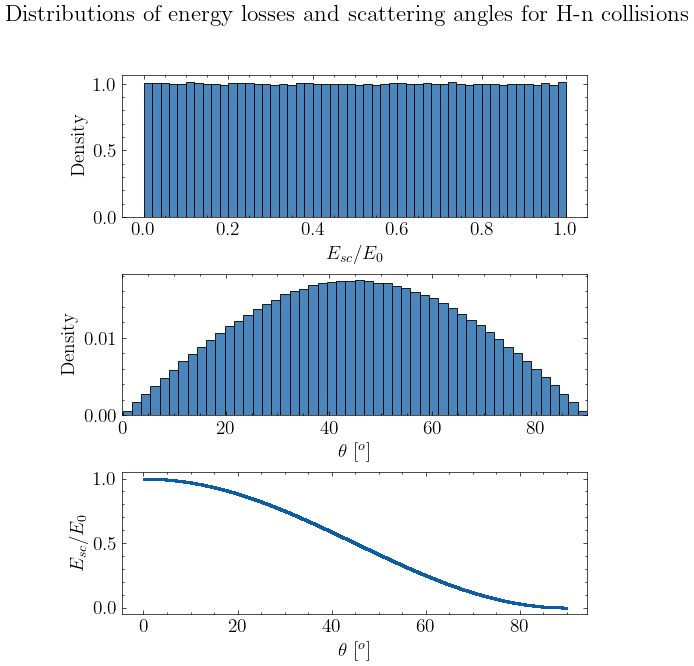

In [2]:
E0 = 1
energies_H = E0 * np.random.random(1000000)
thetas = np.degrees(np.arccos(np.sqrt(energies_H / E0)))

fig, axs = plt.subplots(3, 1)
fig.subplots_adjust(hspace=0.4)

fig.suptitle("Distributions of energy losses and scattering angles for H-n collisions")
sns.histplot(energies_H, bins=50,stat='density', color='C0', ax=axs[0])
axs[0].set_xlabel(r'$E_{sc} / E_0 $')
axs[0].set_ylabel("Density")

sns.histplot(thetas, bins=50,stat='density', color='C0', ax=axs[1])
axs[1].set_xlabel(r'$\theta \ [^o]$')
axs[1].set_ylabel("Density")
axs[1].set_xlim(0, 90)

axs[2].plot(thetas, energies_H, 'o', markersize=1, color='C0')
axs[2].set_ylabel(r'$E_{sc} / E_0 $')
axs[2].set_xlabel(r'$\theta \ [^o]$')

plt.show()

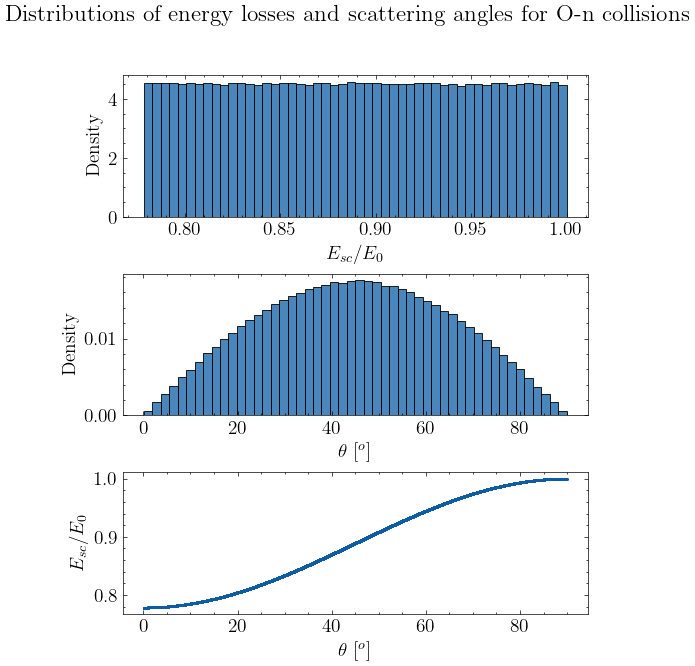

In [4]:
E0 = 1
A = 16
E_min = ((A-1)/(A+1))**2*E0

energies_O = np.random.uniform(E_min, E0, 1000000)

thetas = np.degrees(np.arccos(np.sqrt( ((1+A)**2 / (4*A) )* (E0 - energies_O) / (E0))))

fig, axs = plt.subplots(3, 1)
fig.subplots_adjust(hspace=0.4)

fig.suptitle("Distributions of energy losses and scattering angles for O-n collisions")
sns.histplot(energies_O, bins=50,stat='density', color='C0', ax=axs[0])
axs[0].set_xlabel(r'$E_{sc} / E_0 $')
axs[0].set_ylabel("Density")

sns.histplot(thetas, bins=50,stat='density', color='C0', ax=axs[1])
axs[1].set_xlabel(r'$\theta \ [^o]$')
axs[1].set_ylabel("Density")
#axs[1].set_xlim(0, 90)

axs[2].plot(thetas, energies_O, 'o', markersize=1, color='C0')
axs[2].set_ylabel(r'$E_{sc} / E_0 $')
axs[2].set_xlabel(r'$\theta \ [^o]$')

plt.show()

In [202]:
nCollisions = []
for _ in range(100):
    E = 2*10**6
    thetas = []

    n = 0
    while E > 2:
        if np.random.random() < processor.get_ratio(E):
            # H collision
            E_new =E* energies_H[np.random.randint(0, len(energies_H))]
            thetas.append(np.arccos(np.sqrt(E_new / E)))

        else:
            # O collision
            E_new = E* energies_O[np.random.randint(0, len(energies_O))]
            thetas.append(np.arccos(np.sqrt( ((1+A)**2 / (4*A) )* (E - E_new) / (E))))
        n += 1
    
        E = E_new
    
    nCollisions.append(n)

print(f" <no. collisions> = {np.mean(nCollisions)}")
xi = np.log(E0)/np.mean(nCollisions)
print(f"xi = {xi}")
print(f"<Esc / E0> = {1/np.exp(xi)}")


 <no. collisions> = 16.17
xi = 0.8972577451159071
<Esc / E0> = 0.40768610746822675
